In [31]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import scipy
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import hierarchical_sampling_model
import util
import smoothing_spline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [468]:
import allensdk
import h5py
import pynwb
import pandas
import hdmf
print('allensdk', allensdk.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('pandas', pandas.__version__)
print('hdmf', hdmf.__version__)

allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
pandas 1.1.1
hdmf 2.2.0


In [33]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [34]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

# Load data

### Neurons Selection

In [35]:
probes = ['probeC', 'probeD', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    94
probeE    89
probeD    78
Name: probe_description, dtype: int64

261

## Trials Selection

#### drifting gratings

In [118]:
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x12 7989
# condition_ids = [275, 268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x13 7989

In [36]:
condition_ids = [275, 268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x13 7989
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
hierarchical_sampling_model.HierarchicalSamplingModel.print_conditions(trials_groups)

0  249 temp freq [8.0] orient [90.0] contrast [0.8] [ 3801  3810  3828  3911  3964 31002 31054 31055 31178 49257 49317 49341 49365 49395 49430]
1  256 temp freq [15.0] orient [270.0] contrast [0.8] [ 3811  3845  3942  3958 31003 31056 31112 31126 31137 31169 31191 49260 49305 49344 49381]
2  257 temp freq [8.0] orient [315.0] contrast [0.8] [ 3813  3822  3870  3876  3932  3936  3987 31022 31027 31075 31171 49215 49217 49368 49370]
3  260 temp freq [4.0] orient [315.0] contrast [0.8] [ 3816  3888  3930  3943  3948 31028 31033 31190 49263 49266 49320 49364 49410 49411 49428]
4  261 temp freq [8.0] orient [135.0] contrast [0.8] [ 3817  3826  3875  3928 31020 31053 31129 31161 31162 49230 49254 49268 49275 49313 49407]
5  268 temp freq [4.0] orient [45.0] contrast [0.8] [ 3833  3882  3884  3899  3951  3988 31040 31086 31089 31116 31149 31197 49255 49277 49327]
6  270 temp freq [8.0] orient [45.0] contrast [0.8] [ 3835  3898  3914  3934 31062 31104 31114 49250 49274 49281 49286 49304 49322 

## Spike Trains

In [37]:
data_loader = data_model.AllenInstituteDataModel(session)
trial_time_window=[0.0, 0.5]
dt=0.002
spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)

In [38]:
spike_trains = data_loader.get_trial_metric_per_unit_per_trial(
    stimulus_presentation_ids=all_trials_indices,
    unit_ids=selected_units.index.values,
    trial_time_window=trial_time_window,
    metric_type='spike_trains', dt=dt)
spike_times = data_loader.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_time_window,
        metric_type='spike_times')

In [39]:
display(spike_trains.shape)
# display(spike_trains.head())
display(spike_times.shape)
# display(spike_times.head())

(261, 195)

(261, 195)

# GPFA fitting

In [42]:
np.random.seed(0)
model = hierarchical_sampling_model.HierarchicalSamplingModel(session)
model.initial_step(spike_trains, spike_times, spike_train_time_line, selected_units, trials_groups, 
                   trial_time_window, probes=['probeC', 'probeD', 'probeE'], num_areas=3, num_groups=3,
                   model_feature_type='BSS', prior_type='diag', eta_smooth_tuning=3e-8, verbose=False)

experiment_folder = f'{session_id}_BSS_MC_0_500ms_probeCDE_condition{len(condition_ids)}_diag_prior_alpha5_{time.strftime("%Y%m%d-%H%M%S")}'
batches_dir = project_dir + 'Output/models/'

Model feature type:  BSS
Condition: 0  stimulus_condition_id:249
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  
Condition: 1  stimulus_condition_id:256
probeC g:[2 1 0] counts:[39 32 23]  probeD g:[2 1 0] counts:[33 25 20]  probeE g:[2 1 0] counts:[36 31 22]  
Condition: 2  stimulus_condition_id:257
probeC g:[2 1 0] counts:[39 33 22]  probeD g:[2 1 0] counts:[34 24 20]  probeE g:[2 1 0] counts:[37 30 22]  
Condition: 3  stimulus_condition_id:260
probeC g:[2 1 0] counts:[39 32 23]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[37 30 22]  
Condition: 4  stimulus_condition_id:261
probeC g:[2 1 0] counts:[39 32 23]  probeD g:[2 1 0] counts:[32 26 20]  probeE g:[2 1 0] counts:[37 30 22]  
Condition: 5  stimulus_condition_id:268
probeC g:[2 1 0] counts:[40 30 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[37 30 22]  
Condition: 6  stimulus_condition_id:270
probeC g:[2 1 0] counts:[39 31 24]  probe

### GPFA fitting each trial.

In [348]:
clist = list(range(len(condition_ids)))
neo_spikes = model.extract_neo_spikes_ar(clist)


probeC	num_trial:195	num_neurons:94
probeD	num_trial:195	num_neurons:78
probeE	num_trial:195	num_neurons:89


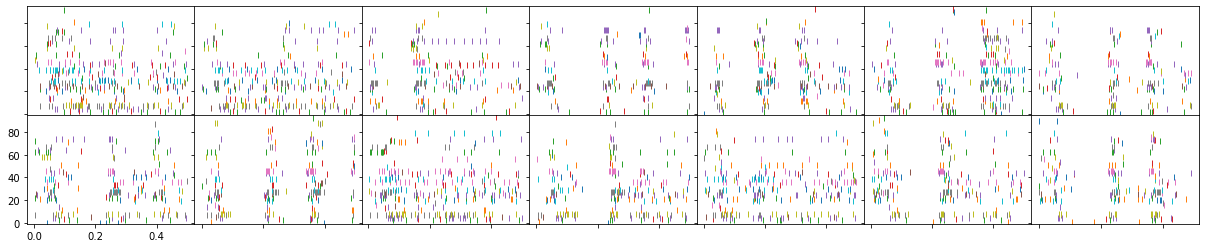

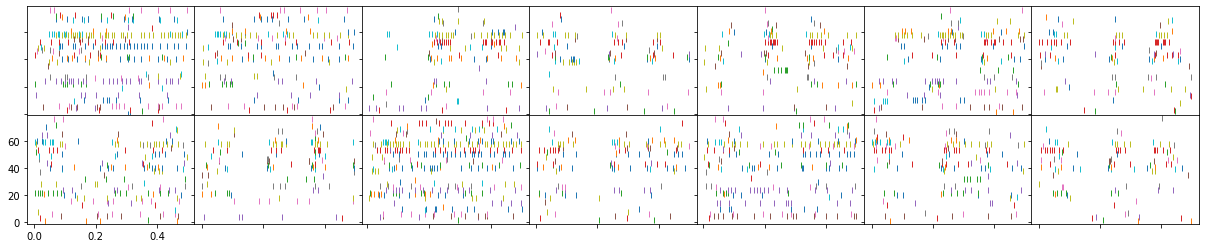

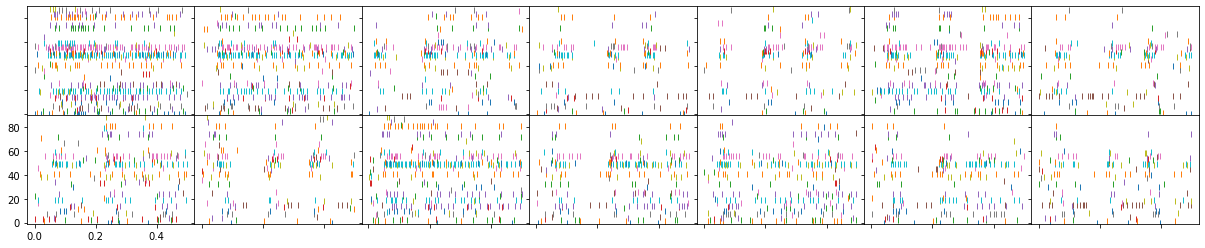

In [350]:
model.plot_neo_spikes(neo_spikes['probeC'], num_trials=14)
model.plot_neo_spikes(neo_spikes['probeD'], num_trials=14)
model.plot_neo_spikes(neo_spikes['probeE'], num_trials=14)

In [406]:
dim = 8
bin_size = 10
gpfa_model_probeC = model.gpfa_fit_arc(neo_spikes['probeC'], dim=dim, bin_size=bin_size)
gpfa_model_probeD = model.gpfa_fit_arc(neo_spikes['probeD'], dim=dim, bin_size=bin_size)
gpfa_model_probeE = model.gpfa_fit_arc(neo_spikes['probeE'], dim=dim, bin_size=bin_size)

Number of training trials: 195
Latent space dimensionality: 8
Observation dimensionality: 94
Initializing parameters using factor analysis...

Fitting GPFA model...
EM iteration: 100%|███████████████████████████████████████████████████████████████████| 500/500 [01:21<00:00,  6.10it/s]
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])
Number of training trials: 195
Latent space dimensionality: 8
Observation dimensionality: 78
Initializing parameters using factor analysis...

Fitting GPFA model...
EM iteration: 100%|███████████████████████████████████████████████████████████████████| 500/500 [01:19<00:00,  6.28it/s]
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])
Number of training trials: 195
Latent space dimensionality: 8
Observation dimensionality: 89
Initializing parameters using factor analysis...

Fitting GPFA model...
EM iteration: 100%|███████████████████████████████████████████████████████████████████| 500/500 [01:19<00:00,  6.26it/s]
dict_keys(['covT

In [407]:
output_dir = project_dir + 'Output/gpfa/'
util.save_variable(output_dir + f'gpfa_model_probeC_dim{dim}_binsize{bin_size}.pkl', gpfa_model_probeC)
util.save_variable(output_dir + f'gpfa_model_probeD_dim{dim}_binsize{bin_size}.pkl', gpfa_model_probeD)
util.save_variable(output_dir + f'gpfa_model_probeE_dim{dim}_binsize{bin_size}.pkl', gpfa_model_probeE)

util.save_variable, save variable to:  D:/Brain_Network/Output/gpfa/gpfa_model_probeC_dim8_binsize10.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/gpfa/gpfa_model_probeD_dim8_binsize10.pkl
util.save_variable, save variable to:  D:/Brain_Network/Output/gpfa/gpfa_model_probeE_dim8_binsize10.pkl


### Results.

In [422]:
model_path = project_dir + 'Output/gpfa/gpfa_model_probeC_dim8_binsize20.pkl'
gpfa_model_probeC = util.load_variable(model_path)
model_path = project_dir + 'Output/gpfa/gpfa_model_probeD_dim8_binsize20.pkl'
gpfa_model_probeD = util.load_variable(model_path)
model_path = project_dir + 'Output/gpfa/gpfa_model_probeE_dim8_binsize20.pkl'
gpfa_model_probeE = util.load_variable(model_path)
bin_size = 20

In [423]:
trajectoriesC = gpfa_model_probeC.transform(neo_spikes['probeC'])
trajectoriesC = np.stack(trajectoriesC, axis=0)
trajectoriesD = gpfa_model_probeD.transform(neo_spikes['probeD'])
trajectoriesD = np.stack(trajectoriesD, axis=0)
trajectoriesE = gpfa_model_probeE.transform(neo_spikes['probeE'])
trajectoriesE = np.stack(trajectoriesE, axis=0)
print('trajectoriesC.shape', trajectoriesC.shape)

trajectoriesC.shape (195, 8, 25)


save figure: D:/Brain_Network/Output/fig/gpfa_dim8_binsize20_c2_r12.pdf


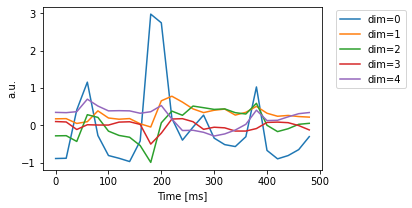

In [464]:
file_path = project_dir + 'Output/fig/gpfa_dim8_binsize20_c2_r12.pdf'
model.plot_gpfa_trajectories_cr(trajectoriesC, c=2, r=2, bin_size=bin_size, file_path=file_path)

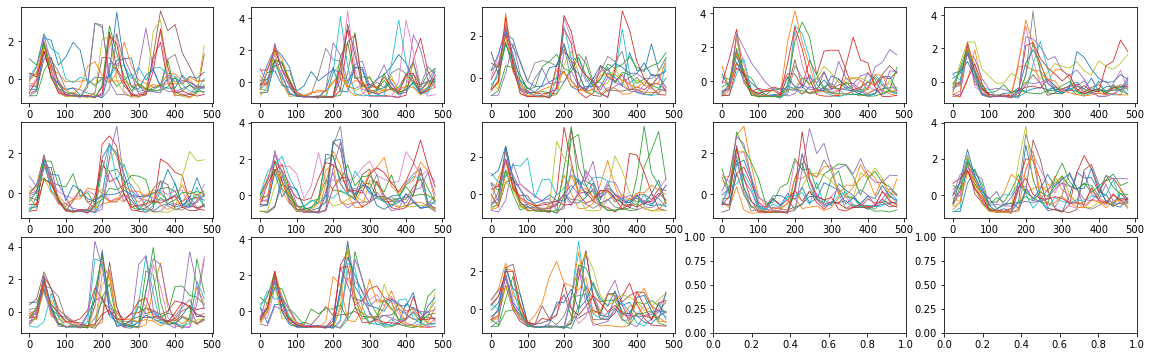

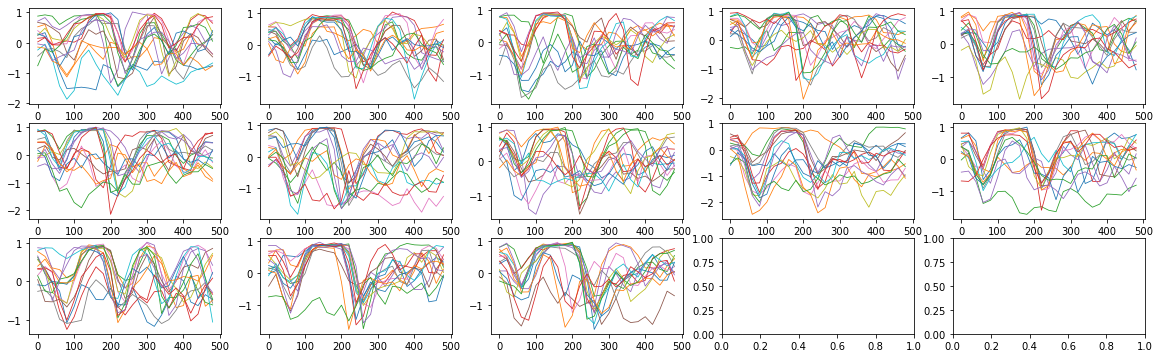

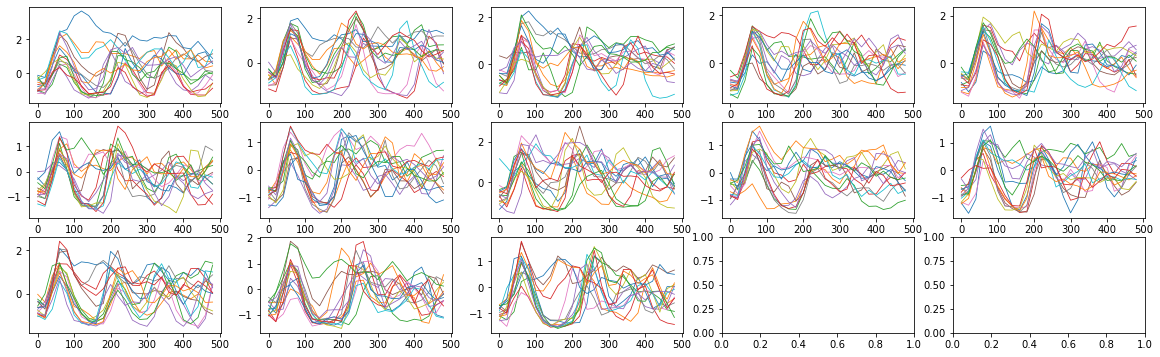

In [494]:
# Select the main PC (dim=0).
model.plot_gpfa_trajectories(trajectoriesC, dim=0, bin_size=bin_size)
model.plot_gpfa_trajectories(trajectoriesD, dim=0, bin_size=bin_size)
model.plot_gpfa_trajectories(trajectoriesE, dim=0, bin_size=bin_size)

trajectories.shape (195, 25)
trajectories.shape (195, 25)
save figure: D:/Brain_Network/Output/fig/798911424_LM_V1_peak1_gpfa.pdf


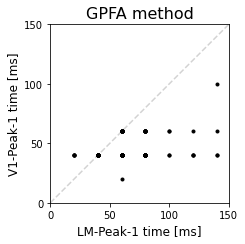

save figure: D:/Brain_Network/Output/fig/798911424_LM_V1_peak2_gpfa.pdf


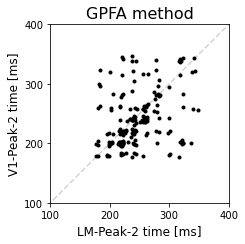

In [492]:
output_dir = project_dir + 'Output/fig/'
gpfa_dt=bin_size / 1000  # sec.
time_line = np.arange(trial_time_window[0], trial_time_window[1], gpfa_dt)
model.plot_gpfa_paired_peaks(-trajectoriesD[:,0], trajectoriesC[:,0], areas0='LM', areas1='V1',
                             time_line=time_line, noise_perturb=True, output_dir=output_dir)

save figure: D:/Brain_Network/Output/fig/798911424_LM_V1_gpfa_PC1_lags.pdf


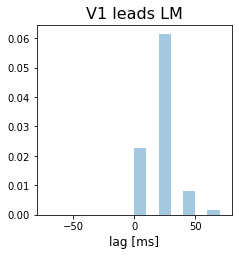

save figure: D:/Brain_Network/Output/fig/798911424_AL_V1_gpfa_PC1_lags.pdf


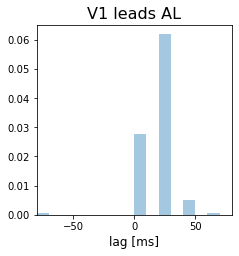

save figure: D:/Brain_Network/Output/fig/798911424_AL_LM_gpfa_PC1_lags.pdf


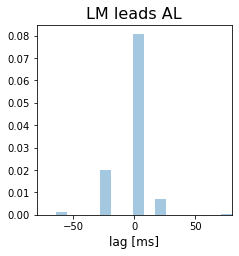

In [500]:
output_dir = project_dir + 'Output/fig/'
gpfa_dt=bin_size / 1000  # sec.
time_line = np.arange(trial_time_window[0], trial_time_window[1], gpfa_dt)
model.plot_gpfa_paired_lags(-trajectoriesD[:,0], trajectoriesC[:,0], areas0='LM', areas1='V1',
                            time_line=time_line, noise_perturb=True, output_dir=output_dir)

model.plot_gpfa_paired_lags(trajectoriesE[:,0], trajectoriesC[:,0], areas0='AL', areas1='V1',
                            time_line=time_line, noise_perturb=True, output_dir=output_dir)

model.plot_gpfa_paired_lags(trajectoriesE[:,0], -trajectoriesD[:,0], areas0='AL', areas1='LM',
                            time_line=time_line, noise_perturb=True, output_dir=output_dir)

# GPFA test
Tutorial link: https://elephant.readthedocs.io/en/latest/tutorials/gpfa.html

In [52]:
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
import elephant
from elephant.spike_train_generation import inhomogeneous_poisson_process


def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))


def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05,
                      sigma=10, rho=28, beta=2.667, tau=1e3):

    def _lorenz_ode(point_of_interest, timepoint, sigma, rho, beta, tau):
        x, y, z = point_of_interest

        x_dot = (sigma*(y - x)) / tau
        y_dot = (rho*x - y - x*z) / tau
        z_dot = (x*y - beta*z) / tau
        return x_dot, y_dot, z_dot

    assert isinstance(num_steps, int), "num_steps has to be integer"

    t = dt*np.arange(num_steps)
    poi = (x0, y0, z0)
    return t, odeint(_lorenz_ode, poi, t, args=(sigma, rho, beta, tau)).T


def random_projection(data, embedding_dimension, loc=0, scale=None):
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)

    return spiketrains

In [122]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 2 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 20 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data size
num_trials = 1
num_spiketrains = 50

# generate a low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1)
times_oscillator = (times_oscillator*timestep.units).rescale('s')

# random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains)

# convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)

# generate spike trains
spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

In [129]:
print(len(spiketrains_oscillator), len(spiketrains_oscillator[0]))
print(spiketrains_oscillator[0])

1 50
[<SpikeTrain(array([0.3735015 , 0.57001916, 0.75074867, 1.20391976]) * s, [0.0 s, 2.0 s])>, <SpikeTrain(array([1.32012156, 1.88586333]) * s, [0.0 s, 2.0 s])>, <SpikeTrain(array([0.35842576, 0.49767313, 1.09548097]) * s, [0.0 s, 2.0 s])>, <SpikeTrain(array([0.1971751 , 0.88480641, 1.1405442 , 1.15499085]) * s, [0.0 s, 2.0 s])>, <SpikeTrain(array([0.93755232, 1.04062231]) * s, [0.0 s, 2.0 s])>, <SpikeTrain(array([0.43616216, 1.39079632]) * s, [0.0 s, 2.0 s])>, <SpikeTrain(array([0.36300999, 0.43256931, 0.62231372, 1.58289894]) * s, [0.0 s, 2.0 s])>, <SpikeTrain(array([0.68876928, 0.68947369, 0.71373942, 0.86668346, 1.67562403, 1.86144822]) * s, [0.0 s, 2.0 s])>, <SpikeTrain(array([0.86470585, 1.68887067, 1.72607948, 1.87638982]) * s, [0.0 s, 2.0 s])>, <SpikeTrain(array([0.6899642 , 1.42623798, 1.60390947, 1.74673387, 1.91351472]) * s, [0.0 s, 2.0 s])>, <SpikeTrain(array([0.20315641, 0.20675743, 1.39882363]) * s, [0.0 s, 2.0 s])>, <SpikeTrain(array([0.30361513, 0.52474939]) * s, [0.0

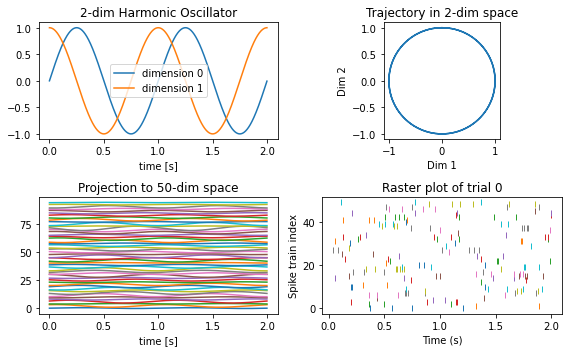

In [130]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 5))

ax1.set_title('2-dim Harmonic Oscillator')
ax1.set_xlabel('time [s]')
for i, y in enumerate(oscillator_trajectory_2dim):
    ax1.plot(times_oscillator, y, label=f'dimension {i}')
ax1.legend()

ax2.set_title('Trajectory in 2-dim space')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('time [s]')
y_offset = oscillator_trajectory_Ndim.std() * 3
for i, y in enumerate(oscillator_trajectory_Ndim):
    ax3.plot(times_oscillator, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike train index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

In [131]:
from elephant.gpfa import GPFA

# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [133]:
# gpfa_2dim.fit(spiketrains_oscillator[:num_trials//2])
gpfa_2dim.fit(spiketrains_oscillator)
print(gpfa_2dim.params_estimated.keys())

Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


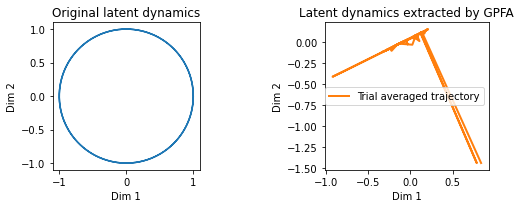

In [134]:
trajectories = gpfa_2dim.transform(spiketrains_oscillator[num_trials//2:])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
ax1.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', 
             lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], '-', 
         lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()

plt.tight_layout()
plt.show()
